In [1]:
!pip install -q diffusers transformers accelerate
!pip install -q https://download.pytorch.org/whl/cu118/torch-2.1.0%2Bcu118-cp310-cp310-linux_x86_64.whl
!pip install -q https://download.pytorch.org/whl/triton-2.1.0-0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
!pip install -q https://download.pytorch.org/whl/cu118/xformers-0.0.22.post4%2Bcu118-cp310-cp310-manylinux2014_x86_64.whl
!pip install -q https://github.com/camenduru/stable-fast/releases/download/colab/stable_fast-0.0.2-cp310-cp310-linux_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.1.0+cu118 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 2.1.0+cu118 which is incompatible.


In [3]:
!ldconfig /usr/lib64-nvidia

In [1]:
import torch, xformers, triton
from diffusers import StableDiffusionPipeline
from sfast.compilers.stable_diffusion_pipeline_compiler import (compile, CompilationConfig)
torch.backends.cuda.matmul.allow_tf32 = True
model = StableDiffusionPipeline.from_pretrained('gsdf/Counterfeit-V2.5', torch_dtype=torch.float16, safety_checker=None).to('cuda')
config = CompilationConfig.Default()
config.enable_xformers = True
config.enable_triton = True
config.enable_cuda_graph = True # After capturing, the model only accepts one fixed image size. If you want the model to be dynamic, don't enable it.
compiled_model = compile(model, config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

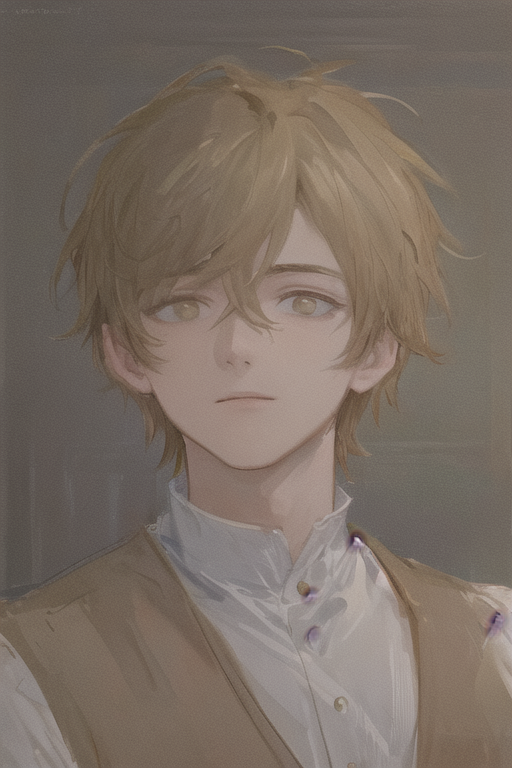

In [10]:
kwarg_inputs = dict(
    prompt=
    '(masterpiece:1,2), best quality, masterpiece, best detail face, 1boy',
    height=768,
    width=512,
    num_inference_steps=30,
    num_images_per_prompt=1,
)
output_image = compiled_model(**kwarg_inputs).images[0] # The first call will trigger compilation and might be very slow. # After the first call, it should be very fast.
output_image